imports

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
plt.style.use('ggplot')

read data

In [56]:
fake_df = pd.read_csv('/content/news/True.csv', delimiter = ',')
real_df = pd.read_csv('/content/news/True.csv', delimiter = ',')

Checking for null values

In [57]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [58]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values for subject

In [59]:
fake_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [60]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Drop the date from the dataset

In [61]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

0 for fake news, and 1 for real news

In [62]:
fake_df['class'] = 0
real_df['class'] = 1

Check out the distribution of fake news compare to real news

Text(0, 0.5, 'Proportion of News Articles')

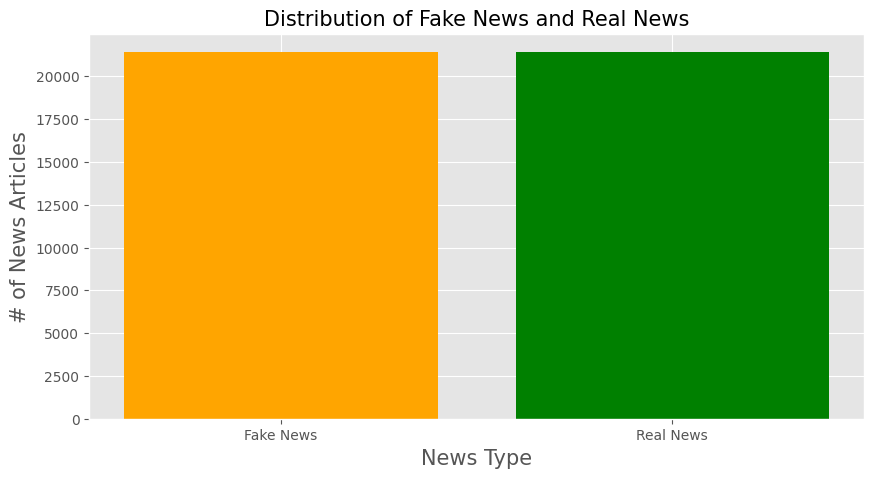

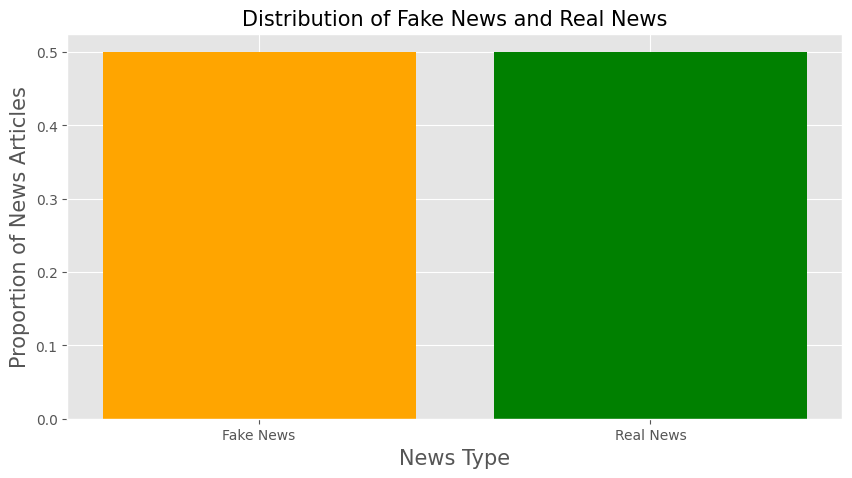

In [63]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [64]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 0


In [65]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...,...
42829,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
42830,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
42831,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
42832,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


Combining the title with the text

In [66]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split into training and testing

In [67]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

Normalizing data: lower case, get rid of extra spaces, and url links.

In [44]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [45]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data.

In [46]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article

In [47]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

using early stop

In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1028/1028 [==============================] - 558s 535ms/step - loss: 0.6934 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5159
Epoch 2/10
1028/1028 [==============================] - 549s 534ms/step - loss: 0.6933 - accuracy: 0.4988 - val_loss: 0.6933 - val_accuracy: 0.5159
Epoch 3/10
1028/1028 [==============================] - 547s 532ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6934 - val_accuracy: 0.5159


Visualize training over time

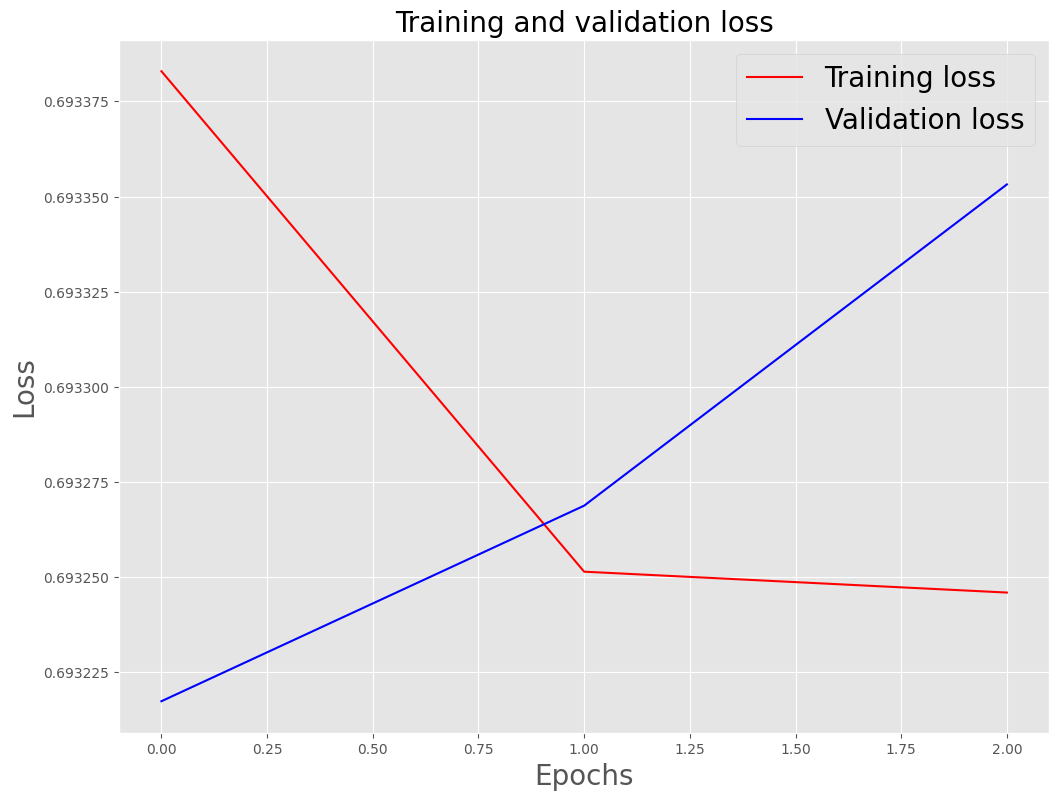

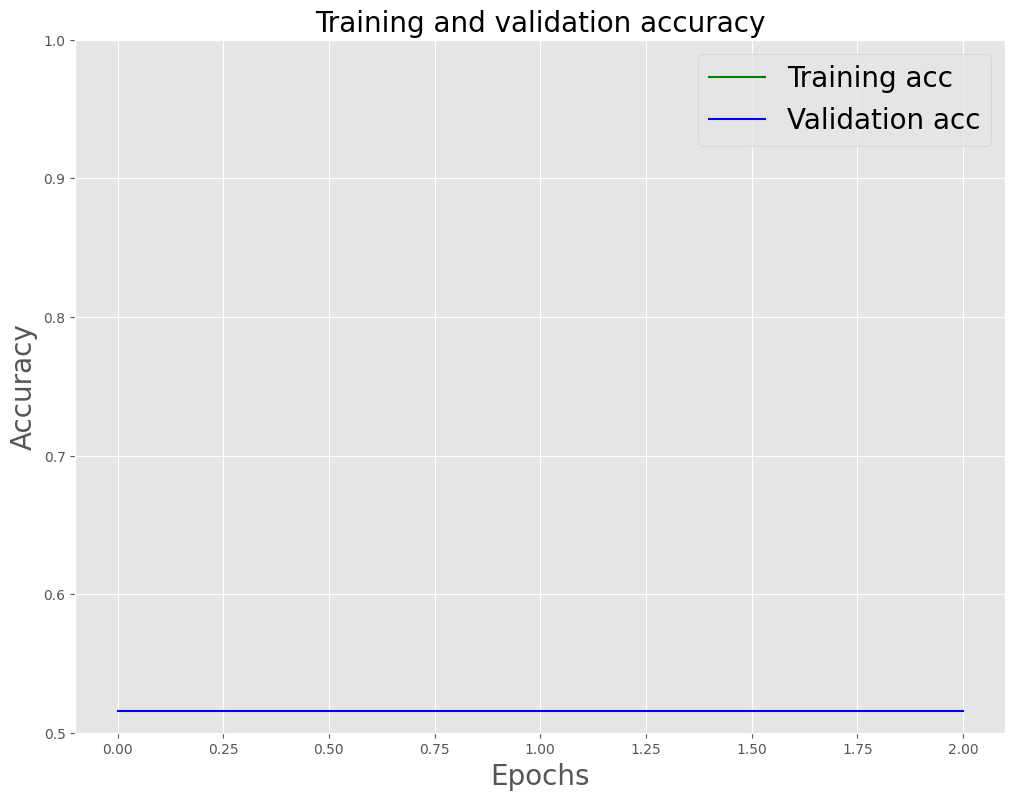

In [50]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set

In [51]:
model.evaluate(X_test, y_test)

268/268 [==============================] - 38s 140ms/step - loss: 0.6932 - accuracy: 0.4981


[0.6932398080825806, 0.4980739951133728]

In [52]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

268/268 [==============================] - 39s 138ms/step


In [53]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.49807400490253295
Precision on testing set: 0.0
Recall on testing set: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix

In [68]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')

from sklearn.metrics import confusion_matrix

# Assuming you have already defined the variables binary_predictions and y_test

# Compute the confusion matrix
confusion_mat = confusion_matrix(binary_predictions, y_test, normalize='all')

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[0.498074 0.501926]
 [0.       0.      ]]
